<h1 style="text-align: center;">SYNTHETIC APERTURE RADAR</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

# Range Imaging

## Window

### Initialize Window

$w(t, T_p)$  
  
$T_p$: Pulse Duration

In [2]:
Tp = 2  # Pulse Duration
delta_t = 1/1000  # Time Increment
t = np.arange(-6, 6, delta_t)

N_total = len(t)  # Number of Total Samples
N_pulse = int(Tp / delta_t)  # Number of Pulse Samples

window = np.zeros(N_total)  # initialize Window with zeros
start, end = (len(t) // 2) - (N_pulse // 2), (len(t) // 2) + (N_pulse // 2)  # Start and End of the Pulse, len(t) // 2: Mid

### Boxcar Window

$
w_{Boxcar}(t, Tp) =
\begin{cases}
1, |t| \leq \frac{T_p}{2}\\\\
0, |t| \gt \frac{T_p}{2}
\end{cases}
$

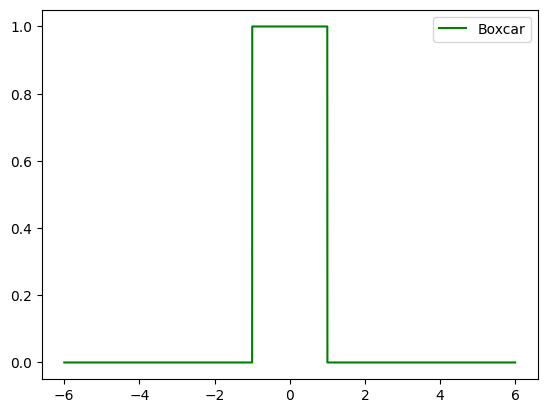

In [3]:
window[start:end] = signal.windows.boxcar(N_pulse)

plt.plot(t, np.real(window), 'g', label='Boxcar')
plt.legend()
plt.draw()

### Kaiser Window

Smoothly taper the edges of the signal. When working in the frequency domain, applying a smoother window reduces energy leakage in the main lobe. It preserves more energy in the main lobe rather than dispersing it into the side lobes. As a result, for Matched Filtering with Fast Fourier Transform (FFT) in the later section, a Kaiser Window over a Boxcar Window helps increase the Signal-to-Noise Ratio (SNR).  
  
$
w_{Kaiser}(t, Tp, \beta) =
\begin{cases}
\frac{1}{T_p}
\frac
    {I_0\{\beta \sqrt{1 - {(2t / T_p)}^2}\}}
    {I_0\{\beta\}}
, |t| \leq \frac{T_p}{2}\\\\
0, |t| \gt \frac{T_p}{2}
\end{cases}
$  
  
$\beta$: Shape Parameter, which controls the trade-off between main-lobe width and side-lobe level. As $\beta$ increases, the window narrows.  
$I_0$: Zeroth-Order Modified Bessel Function

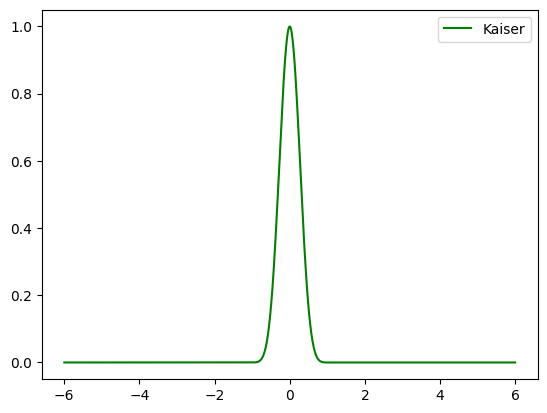

In [4]:
beta = 14
window[start:end] = signal.windows.kaiser(N_pulse, beta)

plt.plot(t, np.real(window), 'g', label='Kaiser')
plt.legend()
plt.draw()

## Transmit Signal

### Linear Frequency-Modulated (LFM) Baseband Form

$s_{tbb}(t) = w(t, T_p) * exp\{ j * \alpha * t^2\}$  
  
$\alpha$: Chirp Rate in radians per second squared

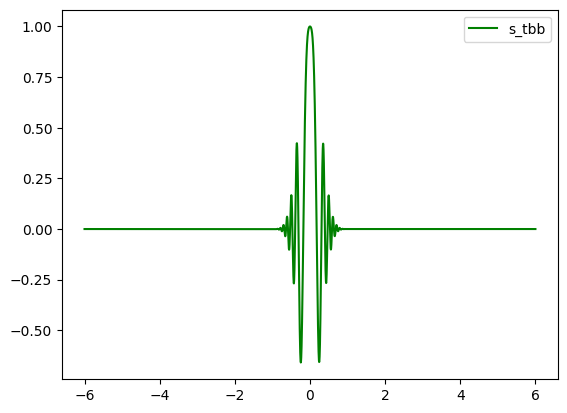

In [5]:
alpha = 2 * np.pi * 8  # Chirp Rate

s_tbb = window * np.exp(1j * alpha * t**2)

plt.plot(t, np.real(s_tbb), 'g', label='s_tbb')
plt.legend()
plt.draw()

### Adjust to Match Carrier Frequency

Ensure $s_{tbb}(t)$ remains centered at the Carrier Frequency  
  
$s_t(t) = s_{tbb}(t) * exp\{j * (\omega_c - \alpha * T_p) * t\}$  
  
$\omega_c$: Carrier Frequency in radians per second

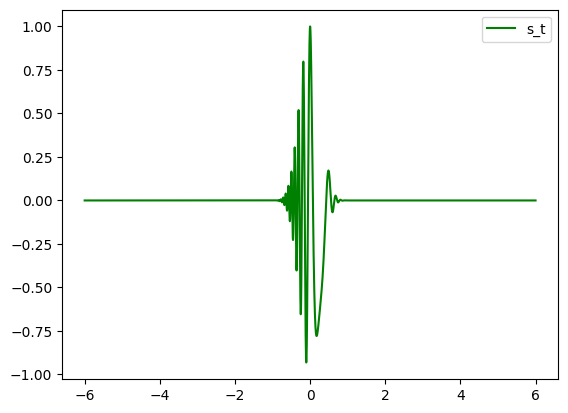

In [6]:
omega = 2 * np.pi * 12  # Carrier Frequency

s_t = s_tbb * np.exp(1j * (omega - alpha * Tp) * t)

plt.plot(t, np.real(s_t), 'g', label='s_t')
plt.legend()
plt.draw()

## Echo Signal

### Simulation

The Transmit Signal generated above is emitted by the radar, reflects off the target, and returns to the radar as the Echo Signal, $s_e(t)$. This process can be simulated using a time shift ($t_0$).  
  
$s_e(t) = \sigma_0 * s_t(t - t_0) = \sigma_0 * w(t, T_p) * exp\{j * \alpha * (t - t_0)^2 + j * (\omega_c - \alpha * T_p) * (t - t_0)\}$  
  
$\sigma_0$: target's Reflectivity  
$t_0$: Round-Trip Delay for the radar signal to travel from the radar transceiver to the target and back  
$t_0 = \frac{2 * d}{c}$  
  
$d$: Physical Distance between the radar and the target  
$c$: Propagation Speed (Speed of Light)

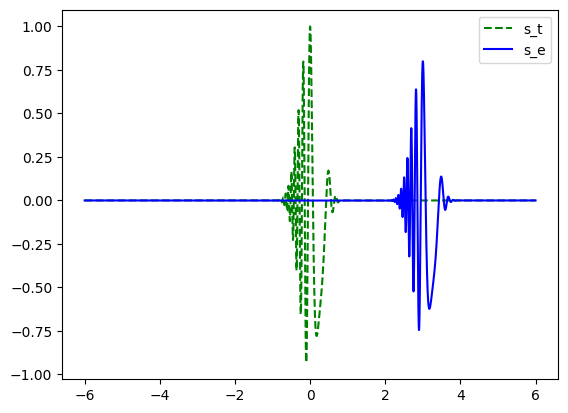

In [7]:
sigma_0 = 0.8  # Reflectivity
t_0 = 3  # Shift Amount

s_e = sigma_0 * np.roll(s_t, int(t_0 / delta_t))

plt.plot(t, np.real(s_t), 'g--', label='s_t')
plt.plot(t, np.real(s_e), 'b', label='s_e')
plt.legend()
plt.draw()

### Adjust Back to Baseband Form

$s_{ebb}(t) = s_e(t) * exp\{-j * (\omega_c - \alpha * T_p) * t\}$

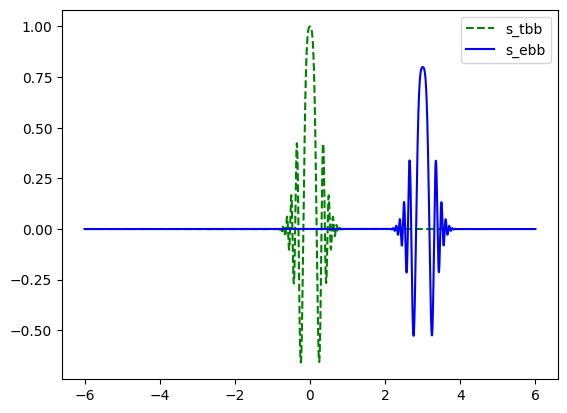

In [8]:
s_ebb = s_e * np.exp(-1j * (omega - alpha * Tp) * t)

plt.plot(t, np.real(s_tbb), 'g--', label='s_tbb')
plt.plot(t, np.real(s_ebb), 'b', label='s_ebb')
plt.legend()
plt.draw()

## Matched Filter

### Matched Filtering to Maximize the Signal-to-Noise Ratio (SNR)

$s_{out}(t) = s_{ebb}(t) \otimes h(t) = s_{ebb}(t) \otimes s_{tbb}^*(-t)$  
  
$\otimes$: Convolution Filtering  
$h(t)$: Matched Filter  
$s_{tbb}^*(-t)$: Time-Reversed, Complex Conjugate of $s_{tbb}(t)$

In [9]:
h = np.conj(s_tbb[::-1])  # [::-1]: Time-Reversed, np.conj: Complex Conjugate
s_out = signal.convolve(s_ebb, h, mode='same', method='direct')

### Fast Fourier Transform (FFT) for Less Computational Burden

$S_{out}(f) = S_{ebb}(f) \cdot H(f) = S_{ebb}(f) \cdot S_{tbb}^*(-f)$  
  
$S_{ebb}(f) = fft\{s_{ebb}(t)\}$  
$H(f) = fft\{h(t)\}$  
$S_{tbb}^*(-f) = fft\{s_{tbb}^*(-t)\}$  
  
$s_{out}(t) = ifft\{S_{out}(f)\}$

In [10]:
s_out = signal.convolve(s_ebb, h, mode='same', method='fft')

### Locate the Peak

$s_{out}(t)$ will peak at $t_0$. Locating the peak is the way to find $t_0$ and, furthermore, to compute the distance between the radar and the target using $d = \frac{t_0 * c}{2}$ with c being the speed of light.

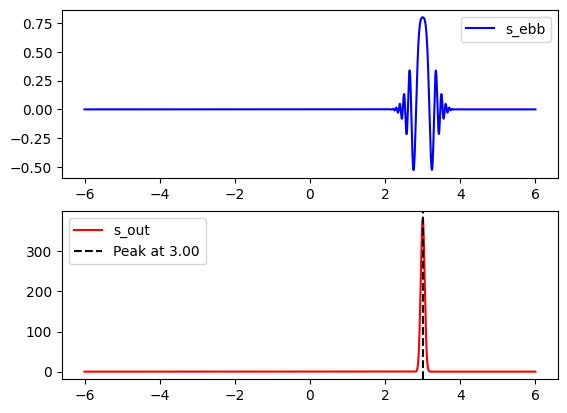

In [11]:
peak_index = np.argmax(np.abs(s_out))

_, axs = plt.subplots(2, 1)
axs[0].plot(t, np.real(s_ebb), 'b', label='s_ebb')
axs[1].plot(t, np.real(s_out), 'r', label='s_out')
axs[1].axvline(t[peak_index], color='k', linestyle='--', label=f'Peak at {t[peak_index]:.2f}')
axs[0].legend()
axs[1].legend()
plt.draw()